In [1]:
import pandas
import numpy as np

In [2]:
resultsRaw = pandas.read_csv('~/Data/Insight/pricing/test_results.csv')
usersRaw = pandas.read_csv('~/Data/Insight/pricing/user_table.csv')

## AB Testing

In [29]:
from scipy.stats import binom

joinedRaw = pandas.merge(resultsRaw,
                  usersRaw, how='left', 
                  left_on=['user_id'], right_on=['user_id'])

groupA = joinedRaw.iloc[joinedRaw['price'].values==39]
groupB = joinedRaw.iloc[joinedRaw['price'].values==59]

print joinedRaw.shape,groupA.shape,groupB.shape

convRateA = float(groupA['converted'].sum())/groupA['converted'].count()
convRateB = float(groupB['converted'].sum())/groupB['converted'].count()
print 'Fraction converted group A: %.4f   Fraction converted group B: %.4f'%(
    convRateA,
    convRateB)

prob = binom.cdf(groupB['converted'].sum(), groupB['converted'].count(), convRateA)
print 'CDF of observing conversion rate B:', prob

(316800, 12) (202672, 12) (114128, 12)
Fraction converted group A: 0.0199   Fraction converted group B: 0.0156
CDF of observing conversion rate B: 1.05985021524e-27


The above means that changing the price is having a statistically significant effect on the conversion rate.

Now, does this actually result in a profit...?

In [30]:
'Average profit per user, group A: %.4f   Avg profit per user, group B: %.4f'%(
    convRateA*39, convRateB*59)

'Average profit per user, group A: 0.7757   Avg profit per user, group B: 0.9186'

Yes, we do see a profit, so we should indeed switch everyone to the $59 price point

## EDA

In [44]:
import matplotlib.pyplot as plt

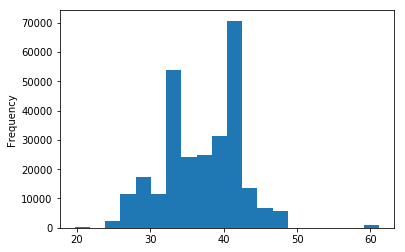

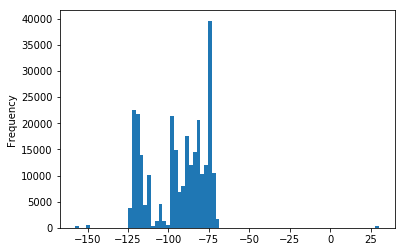

In [57]:
data = joinedRaw

if False:
    print data
    latest_date = data['timestamp'].max()
    data['filled_dates'] = data['timestamp'].fillna(latest_date)
    pandas.to_datetime(data['filled_dates']).dt.dayofweek

plt.figure()
data['lat'].plot.hist(bins=20)
plt.show()

plt.figure()
data['long'].plot.hist(bins=80)
plt.show()


In [78]:
data = joinedRaw

print data.iloc[data['converted'].values==1].sample(n=1000), data.iloc[data['converted'].values==0].shape

data = pandas.concat([data.iloc[data['converted'].values==1].sample(n=1000), 
                      data.iloc[data['converted'].values==0].sample(n=1000)])

data['long_fill'] = data['long'].fillna(-180)
USeast = data['long_fill'].values > -85
UScent = (data['long_fill'].values <= -85) & (data['long_fill'].values > -100)
USwest = data['long_fill'].values <= -100

data['lat_fill'] = data['lat'].fillna(10)
USnorth = data['lat_fill'].values > 37
USsouth = data['lat_fill'].values <= 37

source = pandas.get_dummies(data['source'])
device = pandas.get_dummies(data['source'])
OSes = pandas.get_dummies(data['operative_system'])

print source.shape, device.shape, OSes.shape

        user_id            timestamp           source  device  \
62557    710895  2015-05-03 10:25:05   direct_traffic  mobile   
313681   685401  2015-03-13 17:03:09       ads-google     web   
108818   195611  2015-03-05 11:43:07       ads-google  mobile   
295635   663212  2015-04-19 12:23:20       seo-google  mobile   
43845    460632  2015-03-29 12:15:49         ads-bing  mobile   
92120    948669  2015-03-15 20:23:18         seo-bing  mobile   
13784    948563  2015-03-06 15:56:49       ads-google  mobile   
277636   837251  2015-05-10 18:52:22       ads-google     web   
309480   101406  2015-04-19 10:29:07  friend_referral     web   
154786   136535  2015-04-25 15:46:45   direct_traffic  mobile   
60807     83186  2015-05-08 18:59:21        ads-yahoo  mobile   
28748    575261  2015-05-22 23:11:45   direct_traffic  mobile   
93472    254900  2015-05-05 10:09:55       ads-google     web   
276307   518275  2015-04-16 11:19:06     seo_facebook     web   
303807   545429  2015-05-

In [79]:
nfeatures = 12+12+6

nposts = len(data)
test = ((np.arange(nposts) % 10) == 0) | ((np.arange(nposts) % 10) == 3)
train = np.logical_not(test)
ntrain = len(np.where(train)[0])

if True:
    data_model = np.zeros([nposts,nfeatures])
    data_model[:,0:12] = source.values
    data_model[:,12:24] = device.values
    data_model[:,24:30] = OSes.values
    
    feat_min = []
    feat_max = []
    feat_mean = []
    for i in range(nfeatures):
        feat_min.append(np.min(data_model[:,i]))
        feat_max.append(np.max(data_model[:,i]))
        feat_mean.append(np.mean(data_model[:,i]))
        data_model[:,i] = (data_model[:,i] - feat_mean[i]) / (feat_max[i] - feat_min[i])

    data_train = data_model[train,:]
    data_test = data_model[test,:]
    
    y_model = data['converted'].values
    if False:
        y_min = np.min(y_model)
        y_max = np.max(y_model)
        y_mean = np.mean(y_model)
        y_model = (y_model - y_mean)  / (y_max - y_min)
    y_train = y_model[train]
    y_test = y_model[test]

nposts

2000

96.0


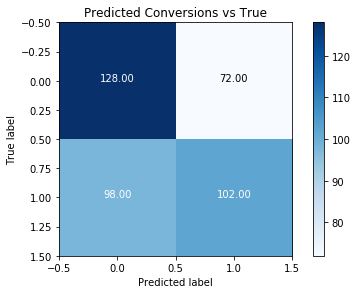

Accuracy: 0.56637   Recall: 0.64000   F1 score: 0.30047 


In [101]:
from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2S, confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Run regression

regr = linear_model.LogisticRegression()
regr.fit(data_train, y_train)

y_pred = regr.predict(data_test)
cm = confusion_matrix(y_test,y_pred)

if True:
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Predicted Conversions vs True')
    plt.colorbar()

    fmt = '.2f' if True else 'd'
    thresh = cm.max() * .75
    print thresh
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color=("white" if (cm[i, j] > thresh) else "black"))

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

accuracy = float(cm[0,0])/(cm[0,0]+cm[1,0])
recall = float(cm[0,0])/(cm[0,0]+cm[0,1])
print "Accuracy: %.5f   Recall: %.5f   F1 score: %.5f "%(accuracy,
                                                    recall,
                                                    accuracy*recall/(accuracy+recall))

In [112]:
features = list(source.columns.values) + list(device.columns.values) + list(OSes.columns.values)

coefficients = pandas.concat([pandas.DataFrame(features),
                              pandas.DataFrame(np.transpose(regr.coef_))], 
                             axis = 1)
print coefficients

                  0         0
0          ads-bing -0.308181
1        ads-google  0.162755
2         ads-yahoo -0.060195
3      ads_facebook  0.105683
4         ads_other -0.055007
5    direct_traffic -0.020944
6   friend_referral  0.431761
7          seo-bing -0.137087
8        seo-google  0.100151
9         seo-other -0.125520
10        seo-yahoo -0.164014
11     seo_facebook  0.070597
12         ads-bing -0.308181
13       ads-google  0.162755
14        ads-yahoo -0.060195
15     ads_facebook  0.105683
16        ads_other -0.055007
17   direct_traffic -0.020944
18  friend_referral  0.431761
19         seo-bing -0.137087
20       seo-google  0.100151
21        seo-other -0.125520
22        seo-yahoo -0.164014
23     seo_facebook  0.070597
24          android -0.078302
25              iOS  0.355569
26            linux -0.186839
27              mac  0.510942
28            other -0.592281
29          windows -0.009089
